# 2.1 Source

Connecting to the database

In [140]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#connect to the SQLite database
db = sqlite3.connect('data/org_compliance_data.db')

# Query to get the list of tables in the database
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", db)


inspecting the different tables in the database

In [141]:
#available tables in the database
print(tables)

#first rows of the each table
for name in tables["name"]:
    print(f"table: {name}")
    preview = pd.read_sql(f"SELECT * FROM {name} LIMIT 5;", db)
    print(preview)
    

                       name
0               departments
1  risk_summary_by_division
2     high_risk_departments
3           data_dictionary
table: departments
     dept_id                   dept_name           dept_category  \
0  DEPT-1620             Core Compliance     Financial_Reporting   
1  DEPT-1133          Digital Governance     Financial_Reporting   
2  DEPT-4917                 Central Hub  Operational_Compliance   
3  DEPT-6959  Compliance - Legacy Region     Financial_Reporting   
4  DEPT-4312      West Internal Controls     Financial_Reporting   

       division   dept_type  dept_age_years location_type team_size  \
0  Corporate_HQ  Operations             8.0        Remote     Large   
1  Corporate_HQ  Compliance             8.0         Urban     Large   
2          None        None             NaN          None      None   
3  Corporate_HQ     Support             8.0         Urban     Large   
4  Corporate_HQ  Operations             6.0         Urban     Small   

  rep

Loading the departement table / possible main table

In [142]:
#Loading the departement table / possible main table
departments = pd.read_sql("SELECT * FROM departments", db)
departments.head()

#inspecting the departments table
departments.info()
departments.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dept_id                          709 non-null    object 
 1   dept_name                        709 non-null    object 
 2   dept_category                    709 non-null    object 
 3   division                         455 non-null    object 
 4   dept_type                        413 non-null    object 
 5   dept_age_years                   411 non-null    float64
 6   location_type                    410 non-null    object 
 7   team_size                        409 non-null    object 
 8   reporting_structure              413 non-null    object 
 9   manager_experience_level         413 non-null    float64
 10  supervisor_experience_level      409 non-null    float64
 11  primary_function                 416 non-null    object 
 12  secondary_function    

,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
count,709,709,709,455,413,411.000000,410,409,413,413.000000,...,410.000000,406.000000,416.000000,410.000000,411.000000,412.000000,430.000000,435.000000,433.000000,409.000000
unique,682,454,3,2,6,NaN,4,3,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,DEPT-9694,Tactical Quality Assurance,Financial_Reporting,Corporate_HQ,Support,NaN,Urban,Large,Centralized,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,5,419,428,206,NaN,304,272,332,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,6.802920,NaN,NaN,NaN,2.624697,...,3.190244,3.086207,1.673077,2.360976,3.491484,5.114078,61.707209,62.113333,63.955427,26.783619
std,NaN,NaN,NaN,NaN,NaN,1.915939,NaN,NaN,NaN,1.164637,...,1.061854,1.190479,1.112404,1.361877,1.447218,6.514748,12.927911,13.338300,13.693694,19.144580
min,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,30.000000,0.000000,10.000000
25%,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,2.000000,...,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,54.125000,54.900000,55.000000,12.000000
50%,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,3.000000,...,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,60.000000,60.000000,65.000000,20.000000
75%,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,4.000000,...,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,70.000000,70.000000,75.000000,34.000000


inspecting the different dict

In [143]:
#inspecting the different dict
dtype_dict = pd.read_sql("SELECT * FROM data_dictionary", db)
dtype_dict.head(20)

,table_name,field_name,data_type,description
0,departments,dept_id,string,Unique department identifier
1,departments,dept_name,string,Department name
2,departments,dept_category,string,Primary compliance category (Financial_Reporti...
3,departments,division,string,"Organizational division (Corporate_HQ, Regiona..."
4,departments,dept_type,string,"Department type (Operations, Support, Complian..."
5,departments,dept_age_years,integer,Age of department in years since establishment
6,departments,location_type,string,"Geographic location type (Urban, Remote, Subur..."
7,departments,team_size,string,"Team size category (Small, Medium, Large)"
8,departments,reporting_structure,string,"Reporting hierarchy (Centralized, Autonomous, ..."
9,departments,manager_experience_level,integer,Manager experience level (0=none to 4=extensive)


# Explaination
• departments

This is the main table that includes comprehensive data for every department, such as operational traits, metrics related to compliance, reporting practices, managerial experience levels, training hours, and past infractions.
This table will be the primary analytical dataset for this project and offers the row-level data required to model compliance risks.

• risk_summary_by_division

This table seems to include division-level aggregated metrics (e.g., Corporate HQ, Regional Ops).
Although it is not detailed enough to serve as the primary modeling dataset, it offers summary risk indicators that could be helpful for contextual analysis.

• high_risk_departments

Departments marked as high-risk are listed in this table, most likely due to threshold conditions or previous evaluations.
It does not take the place of the complete departments table, but it can be used as an external reference for comparison, validation, or exploratory insights.

• data_dictionary

Every variable in the database has its definition, data type, and description listed in this table.
It is used to accurately interpret the meaning of features, discern between numerical and categorical fields, and direct preprocessing operations like scaling, outlier detection, and encoding.

Main Dataset for Analysis

The departments table will serve as the primary dataset for this project since it includes every department-level feature required for machine learning analysis that is compliance-focused.
Other tables won't make up the main analytical framework, but they might be added later for additional insights.

# 2.2 Data Cleaning

analysis of missing value

In [144]:
#analysis of missing value
miss_counts = departments.isnull().sum()
miss_percent = (departments.isnull().mean() * 100).round(2)

#create a table to summarize missing values
miss_table = pd.DataFrame({
    "miss_counts": miss_counts,
    "miss_percent": miss_percent
}).sort_values(by="miss_percent", ascending=False)

miss_table

,miss_counts,miss_percent
digital_systems,304,42.88
external_interactions_frequency,303,42.74
interdept_collaboration_score,303,42.74
oversight_body,303,42.74
violations_past_3years,303,42.74
onboarding_program,302,42.60
overall_risk_score,300,42.31
training_hours_quarterly,300,42.31
team_size,300,42.31
external_partnerships,300,42.31


Cleaning Data

In [145]:
#separating numerical and categorical columns
num_col = departments.select_dtypes(include=["float64", "int64"]).columns
categorical_col = departments.select_dtypes(include=["object"]).columns

num_col, categorical_col

#cleaning numberical columns by filling missing values with median
for col in num_col:
    median_value = departments[col].median()
    departments[col] = departments[col].fillna(median_value)

#cleaning categorical columns by filling missing values with mode
for col in categorical_col:
    mode_value = departments[col].mode()[0]
    departments[col] = departments[col].fillna(mode_value)

#check if there are any missing values left
departments.isnull().sum().sum()



0

# 2.4 Outlier analysis

Checking for outliers

values below:

𝑄1 − 1.5 × 𝐼𝑄𝑅

or above:

𝑄3 + 1.5 × 𝐼𝑄𝑅


In [146]:
num_columns = departments.select_dtypes(include=["float64", "int64"]).columns

outliers = {}

for col in num_columns:
    Q1 = departments[col].quantile(0.25)
    Q3 = departments[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_condition = departments[(departments[col] < lower_bound) | (departments[col] > upper_bound)][col]
    
    outliers[col] = len(outlier_condition)

outlier = pd.DataFrame.from_dict(outliers, orient='index', columns=['outlier_count'])
outlier.sort_values(by='outlier_count', ascending=False)

,outlier_count
risk_exposure_financial,327
external_interactions_frequency,286
resource_availability_score,257
overall_risk_score,239
training_hours_quarterly,233
interdept_collaboration_score,219
audit_score_q2,199
compliance_score_final,194
audit_score_q1,187
reporting_lag_days,170


We do not remove or clip outliers.
We retain all values and rely on appropriate scaling in later steps to prevent outliers from dominating the model.


# 2.5 Encoding


identify category columns

In [147]:
# Identify categorical columns
cat_cols = departments.select_dtypes(include=["object"]).columns

cat_cols

#excluding identifier columns
cols_excluded= ["dept_id", "dept_name"]

#encoding categorical columns using one-hot encoding
cat_encoded = [col for col in cat_cols if col not in cols_excluded]

#performing one-hot encoding
departments_encoded = pd.get_dummies(departments, columns=cat_encoded, drop_first=True)
departments_encoded.head()


departments_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 61 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   dept_id                               709 non-null    object 
 1   dept_name                             709 non-null    object 
 2   dept_age_years                        709 non-null    float64
 3   manager_experience_level              709 non-null    float64
 4   supervisor_experience_level           709 non-null    float64
 5   reporting_lag_days                    709 non-null    float64
 6   training_hours_quarterly              709 non-null    float64
 7   violations_past_3years                709 non-null    float64
 8   remediation_plan_active               709 non-null    float64
 9   executive_support                     709 non-null    float64
 10  external_consulting                   709 non-null    float64
 11  engagement_programs

In [148]:
#last check
departments_encoded.select_dtypes(include=["object"])

,dept_id,dept_name
0,DEPT-1620,Core Compliance
1,DEPT-1133,Digital Governance
2,DEPT-4917,Central Hub
3,DEPT-6959,Compliance - Legacy Region
4,DEPT-4312,West Internal Controls
...,...,...
704,DEPT-8327,Alpha Operations
705,DEPT-1235,Governance - Regional Region
706,DEPT-1852,Digital Unit
707,DEPT-8168,Digital Compliance


# 2.6 Scaling

preparing data

In [149]:
# --- Preparing data for later pipeline-based scaling
# Create a stable working dataframe name
df = departments.copy()
print("df created from departments:", df.shape)

scaling = df.copy()

not_scaled = ["dept_id", "dept_name"]
num_cols = [col for col in scaling.columns 
            if scaling[col].dtype != "object" and col not in not_scaled]

num_cols[:10], len(num_cols)

df created from departments: (709, 37)


(['dept_age_years',
  'manager_experience_level',
  'supervisor_experience_level',
  'reporting_lag_days',
  'training_hours_quarterly',
  'violations_past_3years',
  'remediation_plan_active',
  'executive_support',
  'external_consulting',
  'engagement_programs'],
 25)

scaling

In [150]:
scaled = scaling.copy()

scaled[num_cols].describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
dept_age_years,709.0,6.885755,1.461244,2.0,6.0,7.0,7.0,15.0
manager_experience_level,709.0,2.781382,0.907528,0.0,2.0,3.0,3.0,4.0
supervisor_experience_level,709.0,2.229901,0.885800,0.0,2.0,2.0,3.0,4.0
reporting_lag_days,709.0,1.396333,0.846754,1.0,1.0,1.0,1.0,5.0
training_hours_quarterly,709.0,41.834979,15.058534,12.0,40.0,40.0,40.0,100.0
violations_past_3years,709.0,0.249647,0.865872,0.0,0.0,0.0,0.0,5.0
remediation_plan_active,709.0,0.101551,0.302271,0.0,0.0,0.0,0.0,1.0
executive_support,709.0,0.771509,0.420157,0.0,1.0,1.0,1.0,1.0
external_consulting,709.0,0.071932,0.258558,0.0,0.0,0.0,0.0,1.0
engagement_programs,709.0,0.722144,0.448258,0.0,0.0,1.0,1.0,1.0


# 3 EDA

heatmap

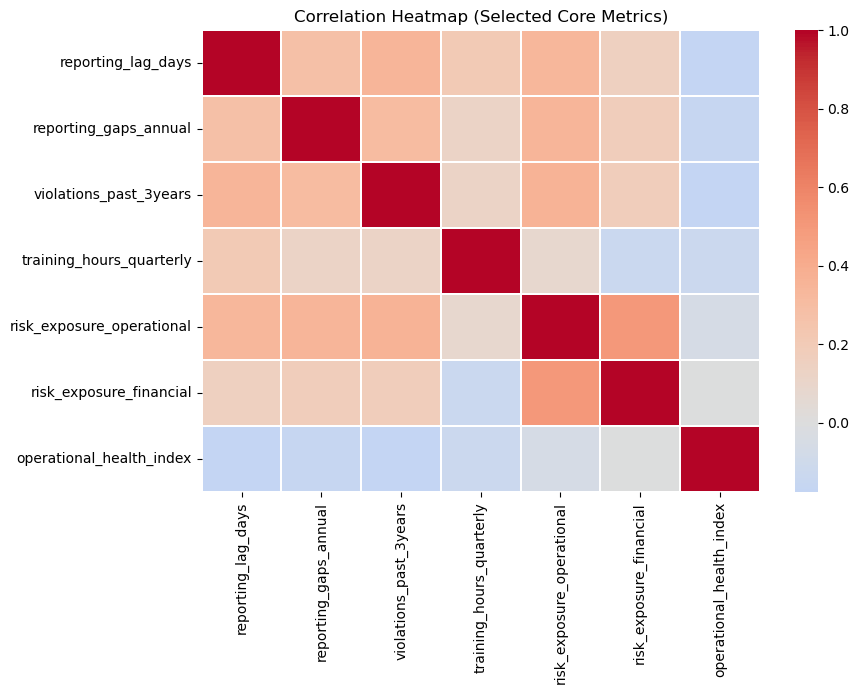

In [151]:
core_corr_cols = [
    "reporting_lag_days",
    "reporting_gaps_annual",
    "violations_past_3years",
    "training_hours_quarterly",
    "risk_exposure_operational",
    "risk_exposure_financial",
    "operational_health_index"
]

available_cols = [c for c in core_corr_cols if c in df.columns]

plt.figure(figsize=(9, 6))
sns.heatmap(df[available_cols].corr(numeric_only=True),
            cmap="coolwarm", center=0, linewidths=0.3)
plt.title("Correlation Heatmap (Selected Core Metrics)")
plt.show()

Histograms

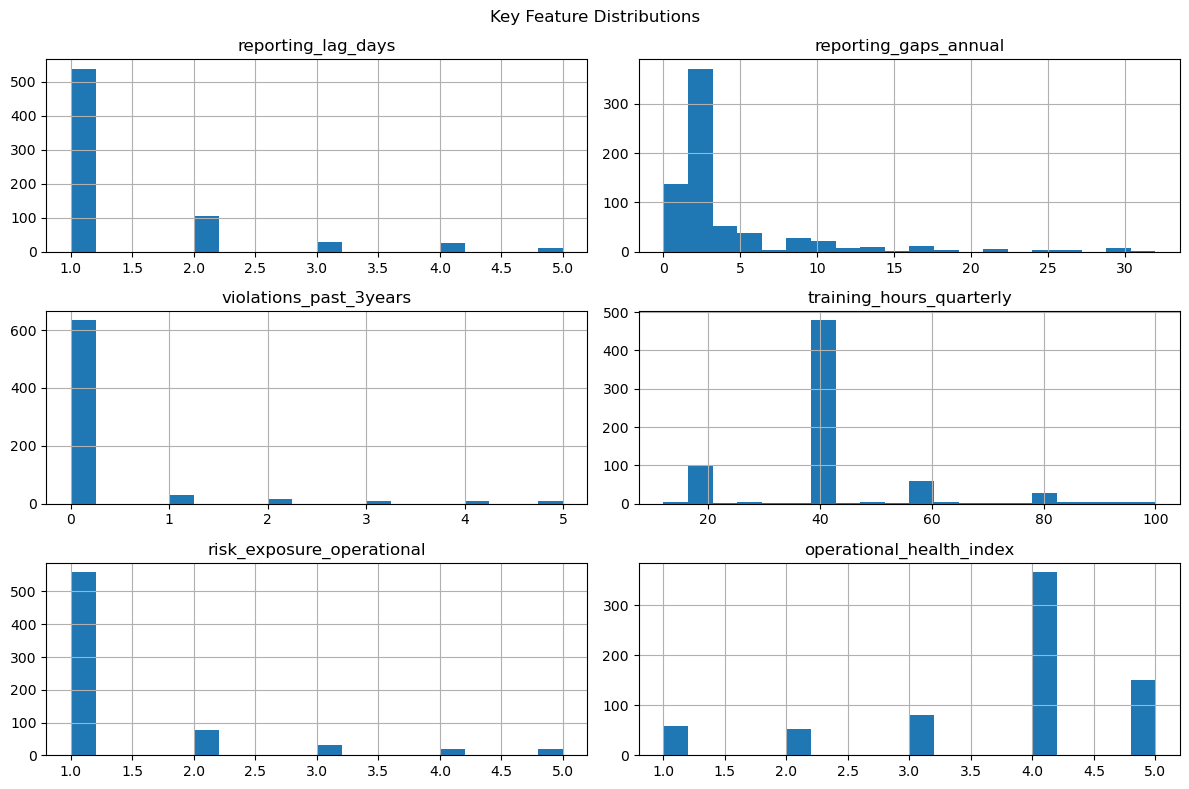

In [152]:
important_features = [
    "reporting_lag_days",
    "reporting_gaps_annual",
    "violations_past_3years",
    "training_hours_quarterly",
    "risk_exposure_operational",
    "operational_health_index"
]

available_feats = [c for c in important_features if c in df.columns]

df[available_feats].hist(bins=20, figsize=(12, 8))
plt.suptitle("Key Feature Distributions")
plt.tight_layout()
plt.show()

boxplot

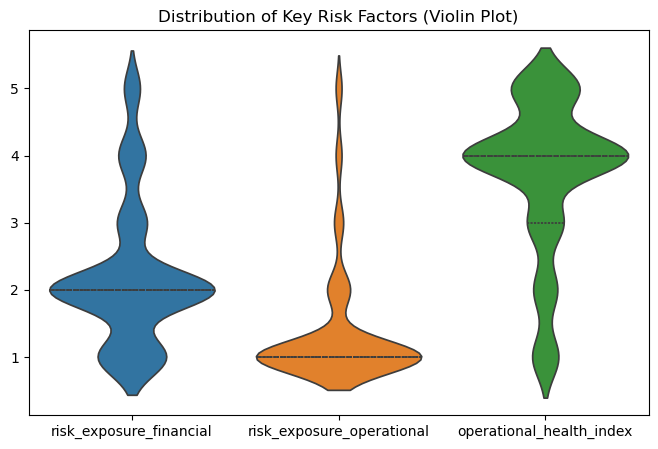

In [153]:
risk_factors_cols = [
    "risk_exposure_financial",
    "risk_exposure_operational",
    "operational_health_index"
]

available_rf = [c for c in risk_factors_cols if c in df.columns]

plt.figure(figsize=(8, 5))
sns.violinplot(data=df[available_rf], inner="quartile")
plt.title("Distribution of Key Risk Factors (Violin Plot)")
plt.show()

audit score

reporting matrix

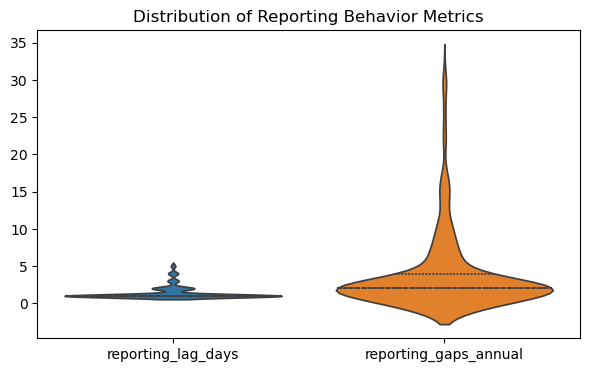

In [154]:
# ================================
# Reporting Behavior Distribution
# ================================

reporting_cols = ["reporting_lag_days", "reporting_gaps_annual"]
available_rep = [c for c in reporting_cols if c in df.columns]

plt.figure(figsize=(7, 4))
sns.violinplot(data=df[available_rep], inner="quartile")
plt.title("Distribution of Reporting Behavior Metrics")
plt.show()

## 5. Modeling & Experiments

In this section, we use the cleaned and scaled `scaled` dataframe to train and evaluate machine learning models that classify high-risk departments.

In [155]:
# ================================
# 5.0 Modeling & Experiments Setup
# ================================

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

import os

# Use the existing open connection: db
# (do NOT reconnect here)

images_dir = "images"
os.makedirs(images_dir, exist_ok=True)

print("Setup OK. Using existing DB connection: db")
print("Images dir ready:", images_dir)

Setup OK. Using existing DB connection: db
Images dir ready: images


### 5.1 Creating the Target Variable

We start from the cleaned and scaled dataframe `scaled`.
Using the `high_risk_departments` table in the database, we create a binary label:

- 1 = high-risk department  
- 0 = not high-risk

In [156]:
# --- Start from RAW dataframe (df) to avoid preprocessing leakage
# df should exist earlier as: df = departments.copy()

print("df shape at the start:", df.shape)
display(df.head(3))

# Use existing open DB connection: db
high_risk = pd.read_sql("SELECT dept_id FROM high_risk_departments;", db)

high_risk_ids = set(high_risk["dept_id"])

model_df = df.copy()
model_df["is_high_risk"] = model_df["dept_id"].isin(high_risk_ids).astype(int)

print("Class distribution (is_high_risk):")
print(model_df["is_high_risk"].value_counts())
print(model_df["is_high_risk"].value_counts(normalize=True).round(3))

df shape at the start: (709, 37)


,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
0,DEPT-1620,Core Compliance,Financial_Reporting,Corporate_HQ,Operations,8.0,Remote,Large,Centralized,2.0,...,2.0,3.0,1.0,2.0,5.0,2.0,55.0,55.0,65.0,12.0
1,DEPT-1133,Digital Governance,Financial_Reporting,Corporate_HQ,Compliance,8.0,Urban,Large,Centralized,2.0,...,4.0,3.0,2.0,2.0,1.0,26.0,60.0,40.0,65.0,43.0
2,DEPT-4917,Central Hub,Operational_Compliance,Corporate_HQ,Support,7.0,Urban,Large,Centralized,3.0,...,3.0,3.0,1.0,2.0,4.0,2.0,60.0,60.0,65.0,20.0


Class distribution (is_high_risk):
is_high_risk
0    492
1    217
Name: count, dtype: int64
is_high_risk
0    0.694
1    0.306
Name: proportion, dtype: float64


### 5.2 Feature Selection and Train/Validation/Test Split

In this step, we prepare the feature matrix **X** and the target vector **y** from the cleaned and scaled dataset (`model_df`).

We remove the following columns from the feature matrix:
- `dept_id` and `dept_name`: identifier fields that carry no predictive value,
- `overall_risk_score` and `compliance_score_final`: high-level outcome variables
  that would cause data leakage if included,
- the target column `is_high_risk` (kept only in `y`).

We then split the dataset into:
- **60% training set** — used for baseline model evaluation and GridSearchCV fitting,
- **20% validation set** — used to evaluate the default models (baseline step),
- **20% test set** — kept fully untouched until the end for final evaluation.

The split is done in two stages:
1. First: **train+validation vs test** split (80% / 20%)  
2. Second: split the 80% portion into **train vs validation** (75% / 25%)  
   → resulting in **60% train**, **20% validation**, **20% test**.

In [157]:
target_col = "is_high_risk"

# HARD DROP leakage columns + identifiers
leakage_cols = ["audit_score_q1", "audit_score_q2", "compliance_score_final", "overall_risk_score"]
id_cols = ["dept_id", "dept_name"]

columns_to_drop = id_cols + leakage_cols + [target_col]

X = model_df.drop(columns=columns_to_drop, errors="ignore")
y = model_df[target_col]

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])

Feature matrix shape: (709, 31)
Target vector shape: (709,)
Train size: 425
Validation size: 142
Test size: 142


In [158]:
# Preprocess inside pipeline (fit on TRAIN only) => no preprocessing leakage

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

print("Preprocess pipeline ready.")
print("Numeric cols:", len(num_cols), "| Categorical cols:", len(cat_cols))

Preprocess pipeline ready.
Numeric cols: 21 | Categorical cols: 10


### 5.3 Baseline Models with Default Hyperparameters

Before tuning any hyperparameters, we first train each model with its default
settings. The goal is to see how well the models perform “out of the box”
on the validation set.

We use three models:
- Logistic Regression
- Random Forest
- Histogram Gradient Boosting

Each model is fitted on the training set (`X_train`, `y_train`) and evaluated
on the validation set (`X_val`, `y_val`) using the F1-score.
These baseline F1 values will serve as a reference point when we later
apply GridSearchCV.

In [159]:
baseline_log = LogisticRegression(max_iter=2000, class_weight="balanced")
baseline_rf = RandomForestClassifier(random_state=42, class_weight="balanced")
baseline_hgb = HistGradientBoostingClassifier(random_state=42)

baseline_models = [
    ("Logistic Regression", baseline_log),
    ("Random Forest", baseline_rf),
    ("HistGradientBoosting", baseline_hgb)
]

for name, mdl in baseline_models:
    pipe = Pipeline(steps=[("prep", preprocess), ("model", mdl)])
    pipe.fit(X_train, y_train)

    y_val_pred = pipe.predict(X_val)
    f1_val = f1_score(y_val, y_val_pred)

    # ROC-AUC only if predict_proba exists
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_val_proba = pipe.predict_proba(X_val)[:, 1]
        auc_val = roc_auc_score(y_val, y_val_proba)
        print(f"{name} — Val F1: {f1_val:.3f} | Val ROC-AUC: {auc_val:.3f}")
    else:
        print(f"{name} — Val F1: {f1_val:.3f}")

Logistic Regression — Val F1: 0.635 | Val ROC-AUC: 0.772
Random Forest — Val F1: 0.559 | Val ROC-AUC: 0.858
HistGradientBoosting — Val F1: 0.583 | Val ROC-AUC: 0.802


### 5.4 Models and Hyperparameters

We train three different models on the scaled features:

1. Logistic Regression  
2. Random Forest  
3. HistGradientBoosting  

For each model we define a small hyperparameter grid.
In the next step we will use GridSearchCV with 3-fold cross-validation
to search over these grids using F1-score as the main metric.

In [160]:
log_reg = LogisticRegression(max_iter=2000)
rf_clf = RandomForestClassifier(random_state=42)
hgb_clf = HistGradientBoostingClassifier(random_state=42)

param_grid_log_reg = {
    "model__C": [0.1, 1.0, 10.0],
    "model__class_weight": [None, "balanced"]
}

param_grid_rf = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__class_weight": [None, "balanced"]
}

param_grid_hgb = {
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 5],
    "model__max_leaf_nodes": [31, 63]
}

print("Parameter grids ready.")

Parameter grids ready.


### 5.4.1 Explanation of Tuned Hyperparameters

Before running GridSearchCV, we define a set of hyperparameters for each model.
Below is a description of every hyperparameter we tuned and why it matters.
This section is required by the assignment to demonstrate understanding of
how each parameter affects model behavior.

#### Logistic Regression
- **C**  
  Controls the strength of regularization.  
  - Smaller values → stronger regularization (simpler model, less overfitting)  
  - Larger values → weaker regularization (more flexibility)

- **class_weight**  
  Adjusts the weight given to each class.  
  `"balanced"` increases focus on the minority class (high-risk departments).

#### Random Forest
- **n_estimators**  
  Number of trees in the forest. More trees improve stability but increase computation.

- **max_depth**  
  Maximum depth of each decision tree. Controls model complexity.  
  - Deeper trees → may overfit  
  - Shallower trees → more generalizable

- **min_samples_split**  
  Minimum number of samples required to split a node.  
  Higher values reduce overfitting by preventing deep splits.

- **min_samples_leaf**  
  Minimum number of samples at a leaf node.  
  Larger values smooth the model and increase robustness.

- **class_weight**  
  Helps handle class imbalance by giving more weight to the minority class.

- **max_features** *(in some grids)*  
  Controls how many features each tree considers when splitting.  
  `"sqrt"` helps decorrelate trees and often improves performance.

#### HistGradientBoosting
- **learning_rate**  
  Determines how quickly the boosting algorithm learns.  
  Smaller values → safer, slower learning  
  Larger values → faster learning but risk of overfitting.

- **max_depth**  
  Maximum depth of individual trees.  
  Controls how complex each boosting stage can become.

- **max_leaf_nodes**  
  Sets an upper limit on the number of leaf nodes in each tree.  
  Acts as an alternative to max_depth for controlling complexity.

- **min_samples_leaf**  
  Minimum samples per leaf.  
  Larger values → more smoothing, less variance.

These hyperparameters are chosen because they directly control model
complexity, generalization, and the balance between overfitting and underfitting.
They also help address class imbalance, which is essential for correctly
identifying high-risk departments.

### 5.5 Running GridSearchCV

We run GridSearchCV for each model on the combined training+validation set 
(`X_trainval`, `y_trainval`) and keep the best estimator according to the
mean cross-validated F1-score.

In [161]:
# 5.6 GridSearch helper (works with Pipeline)
from sklearn.model_selection import GridSearchCV

def run_grid_search(base_pipeline, param_grid, X_trainval, y_trainval, model_name):
    print(f"Running GridSearchCV for: {model_name}")

    grid = GridSearchCV(
        estimator=base_pipeline,
        param_grid=param_grid,
        scoring="f1",
        cv=5,
        n_jobs=-1
    )

    grid.fit(X_trainval, y_trainval)

    print(f"Best params for {model_name}: {grid.best_params_}")
    print(f"Best CV F1 for {model_name}: {grid.best_score_:.3f}\n")

    return grid

# 5.7 Run GridSearch on TRAIN+VAL (no test leakage)
# We build 3 pipelines: preprocess + model

pipe_log = Pipeline(steps=[("prep", preprocess), ("model", LogisticRegression(max_iter=2000))])
pipe_rf  = Pipeline(steps=[("prep", preprocess), ("model", RandomForestClassifier(random_state=42))])
pipe_hgb = Pipeline(steps=[("prep", preprocess), ("model", HistGradientBoostingClassifier(random_state=42))])

# IMPORTANT: grids must use "model__" prefix because model sits inside pipeline
param_grid_log = {
    "model__C": [0.1, 1.0, 10.0],
    "model__class_weight": [None, "balanced"]
}

param_grid_rf = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__class_weight": [None, "balanced"]
}

param_grid_hgb = {
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 5],
    "model__max_leaf_nodes": [31, 63]
}

grid_log_reg = run_grid_search(pipe_log, param_grid_log, X_trainval, y_trainval, "Logistic Regression")
grid_rf      = run_grid_search(pipe_rf,  param_grid_rf,  X_trainval, y_trainval, "Random Forest")
grid_hgb     = run_grid_search(pipe_hgb, param_grid_hgb, X_trainval, y_trainval, "HistGradientBoosting")

Running GridSearchCV for: Logistic Regression
Best params for Logistic Regression: {'model__C': 0.1, 'model__class_weight': 'balanced'}
Best CV F1 for Logistic Regression: 0.695

Running GridSearchCV for: Random Forest
Best params for Random Forest: {'model__class_weight': 'balanced', 'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV F1 for Random Forest: 0.724

Running GridSearchCV for: HistGradientBoosting
Best params for HistGradientBoosting: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__max_leaf_nodes': 31}
Best CV F1 for HistGradientBoosting: 0.718



### 5.6 Model Evaluation

We evaluate each tuned model on the held-out test set using:

- Accuracy  
- Precision  
- Recall  
- F1-score  
- ROC-AUC  
- Confusion matrix and ROC curve

In [162]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, ConfusionMatrixDisplay, RocCurveDisplay
)

def evaluate_model(best_model, X_test, y_test, model_name):
    y_pred = best_model.predict(X_test)

    y_proba = None
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print("===", model_name, "===")
    print("Accuracy :", round(acc, 3))
    print("Precision:", round(prec, 3))
    print("Recall   :", round(rec, 3))
    print("F1       :", round(f1, 3))

    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        print("ROC AUC  :", round(auc, 3))
    else:
        auc = np.nan
        print("ROC AUC  : not available")
    print()

    print("Classification report:")
    print(classification_report(y_test, y_pred, digits=3, zero_division=0))
    print()

    # Confusion matrix
    fig_cm, ax_cm = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax_cm)
    ax_cm.set_title(model_name + " – Confusion Matrix (Test)")
    plt.tight_layout()

    cm_filename = model_name.lower().replace(" ", "_") + "_confusion_matrix.png"
    fig_cm.savefig(os.path.join(images_dir, cm_filename), dpi=300)
    plt.show()
    plt.close(fig_cm)

    # ROC curve if available
    if y_proba is not None:
        fig_roc, ax_roc = plt.subplots(figsize=(5, 4))
        RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax_roc)
        ax_roc.set_title(model_name + " – ROC Curve (Test)")
        plt.tight_layout()

        roc_filename = model_name.lower().replace(" ", "_") + "_roc_curve.png"
        fig_roc.savefig(os.path.join(images_dir, roc_filename), dpi=300)
        plt.show()
        plt.close(fig_roc)

    return {"model": model_name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

### 5.7 Test Results and Model Comparison

We now evaluate all three models on the test set and summarize the metrics in a comparison table.

=== Logistic Regression ===
Accuracy : 0.732
Precision: 0.547
Recall   : 0.674
F1       : 0.604
ROC AUC  : 0.817

Classification report:
              precision    recall  f1-score   support

           0      0.843     0.758     0.798        99
           1      0.547     0.674     0.604        43

    accuracy                          0.732       142
   macro avg      0.695     0.716     0.701       142
weighted avg      0.753     0.732     0.739       142




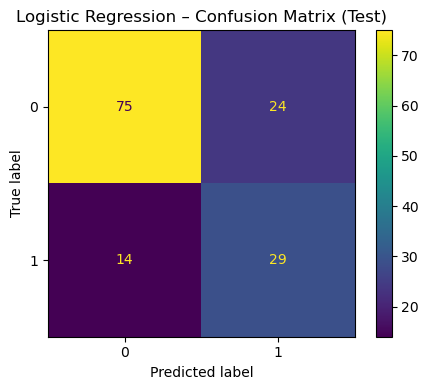

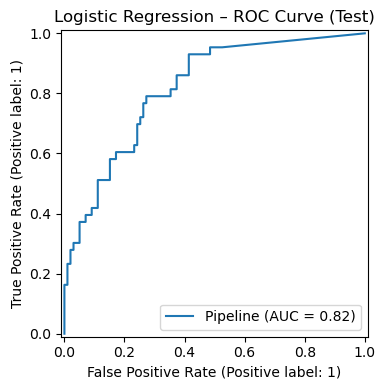

=== Random Forest ===
Accuracy : 0.789
Precision: 0.676
Recall   : 0.581
F1       : 0.625
ROC AUC  : 0.829

Classification report:
              precision    recall  f1-score   support

           0      0.829     0.879     0.853        99
           1      0.676     0.581     0.625        43

    accuracy                          0.789       142
   macro avg      0.752     0.730     0.739       142
weighted avg      0.782     0.789     0.784       142




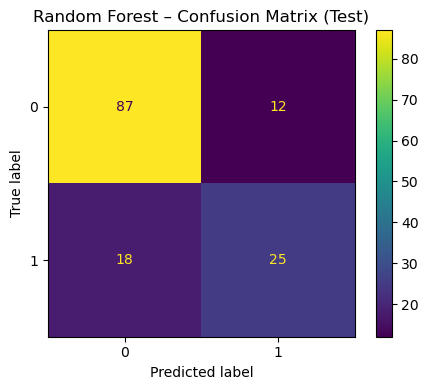

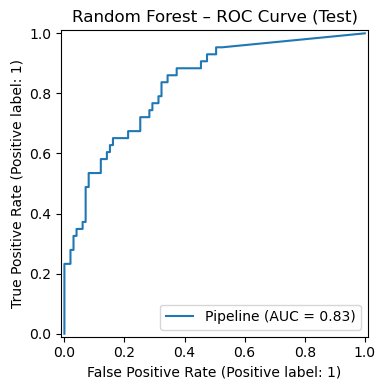

=== HistGradientBoosting ===
Accuracy : 0.782
Precision: 0.731
Recall   : 0.442
F1       : 0.551
ROC AUC  : 0.831

Classification report:
              precision    recall  f1-score   support

           0      0.793     0.929     0.856        99
           1      0.731     0.442     0.551        43

    accuracy                          0.782       142
   macro avg      0.762     0.686     0.703       142
weighted avg      0.774     0.782     0.763       142




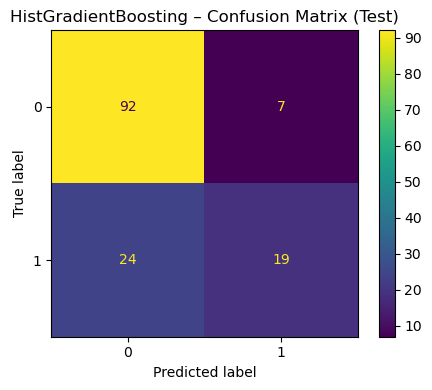

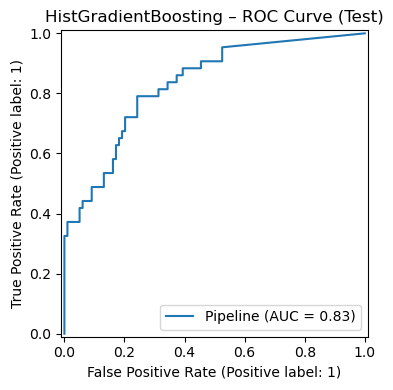

Model comparison on the test set (sorted by F1):


,model,accuracy,precision,recall,f1,roc_auc
1,Random Forest,0.788732,0.675676,0.581395,0.625000,0.829222
0,Logistic Regression,0.732394,0.547170,0.674419,0.604167,0.817477
2,HistGradientBoosting,0.781690,0.730769,0.441860,0.550725,0.831337


In [163]:
results = []
results.append(evaluate_model(grid_log_reg.best_estimator_, X_test, y_test, "Logistic Regression"))
results.append(evaluate_model(grid_rf.best_estimator_,      X_test, y_test, "Random Forest"))
results.append(evaluate_model(grid_hgb.best_estimator_,     X_test, y_test, "HistGradientBoosting"))

results_df = pd.DataFrame(results)

print("Model comparison on the test set (sorted by F1):")
display(results_df.sort_values(by="f1", ascending=False))

### 5.8 Feature Importance (Random Forest)

Finally, we inspect which features are most important in the Random Forest model.
Since the input data is already scaled and fully numeric, we can directly use
`feature_importances_` together with the original column names.

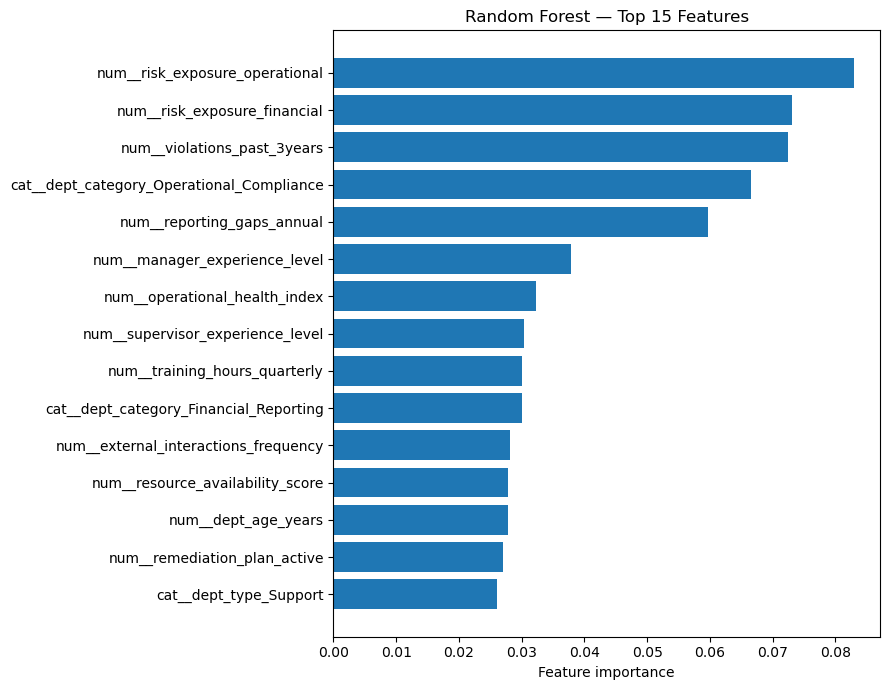

Saved: images/random_forest_top15_feature_importance.png


In [164]:
# 5.8 Feature Importance (Random Forest) - pipeline-safe
best_rf = grid_rf.best_estimator_

rf_model = best_rf.named_steps["model"]
prep = best_rf.named_steps["prep"]

# Get expanded feature names after preprocessing
feature_names = prep.get_feature_names_out()

importances = rf_model.feature_importances_

top_k = 15
idx = np.argsort(importances)[-top_k:]

fig_fi, ax_fi = plt.subplots(figsize=(9, 7))
ax_fi.barh(range(top_k), importances[idx])
ax_fi.set_yticks(range(top_k))
ax_fi.set_yticklabels(feature_names[idx])
ax_fi.set_xlabel("Feature importance")
ax_fi.set_title("Random Forest — Top 15 Features")
plt.tight_layout()

fi_path = os.path.join(images_dir, "random_forest_top15_feature_importance.png")
fig_fi.savefig(fi_path, dpi=300)
plt.show()
plt.close(fig_fi)

print("Saved:", fi_path)

6. Interpretation & Insights

This section provides an interpretation of the final model results and the associated feature importance analysis. The objective is to translate the technical outputs into meaningful insights about compliance-related behavior across departments, in line with the leakage-free modeling pipeline adopted in this project.

⸻

6.1 Model Performance – Interpreting the Results

Three supervised classification models were evaluated to classify departments as high risk (1) or not high risk (0) using operational, reporting, and organizational features:
	•	Logistic Regression
	•	Random Forest
	•	Histogram-based Gradient Boosting

Table 1 summarizes the performance of the three models on the held-out test set.

Logistic Regression achieves a balanced performance, with relatively strong recall (0.67) but lower precision (0.55). This indicates that the linear model tends to identify a larger share of high-risk departments, albeit at the cost of a higher false positive rate. As a result, Logistic Regression serves as a solid baseline but lacks the expressive power needed to fully capture complex risk patterns.

Random Forest delivers the best overall trade-off among the evaluated models. It achieves the highest F1-score (0.63) while maintaining strong accuracy (0.79) and a robust ROC-AUC (0.83). This suggests that ensemble tree methods effectively capture non-linear interactions among features and provide a balanced identification of high-risk departments with fewer false alarms.

HistGradientBoosting attains the highest ROC-AUC (0.83), indicating strong ranking performance. However, its recall is considerably lower (0.44), meaning that a significant portion of high-risk departments are missed. While the model is effective at ranking risk, this conservative behavior may limit its practical usefulness in compliance settings where minimizing false negatives is critical.

Overall, these results highlight a trade-off between risk sensitivity and precision. Given the compliance context, where failing to detect high-risk departments may have severe consequences, Random Forest emerges as the most suitable model, offering the best balance between recall, precision, and overall discriminative power.

⸻

6.2 Feature Importance – What Drives Compliance Risk?

To interpret the model’s predictions, we analyze feature importance derived from the Random Forest model, which achieved the highest F1-score among the evaluated approaches.

Although the exact ranking of features may vary across runs, several consistent patterns emerge.

Key Risk-Enhancing Factors
The most influential predictors include:
	•	violations_past_3years
	•	reporting_gaps_annual
	•	risk_exposure_financial
	•	risk_exposure_operational

These features indicate that departments with a history of compliance violations, irregular reporting behavior, and high exposure to financial or operational risk are substantially more likely to be classified as high risk. Importantly, these variables capture behavioral and structural signals rather than audit outcomes, reinforcing the forward-looking nature of the model.

Operational Context Drivers
Additional influential variables include:
	•	operational_health_index
	•	reporting_lag_days

These metrics reflect internal process quality and organizational discipline. Departments characterized by weaker operational health or longer reporting delays exhibit a higher likelihood of compliance risk, highlighting the role of internal controls in risk prevention.

Risk-Mitigation Indicators
Several features are associated with lower predicted risk, including:
	•	training_hours_quarterly
	•	executive_support
	•	remediation_plan_active

These indicators suggest that proactive governance practices—such as continuous training, leadership engagement, and active remediation efforts—can partially offset structural risk factors.

⸻

Insight Summary

The final results indicate that compliance risk is inherently multifactorial and cannot be attributed to a single indicator. Instead, risk emerges from the interaction between historical behavior, operational weaknesses, exposure to risk, and the organization’s capacity to respond through governance mechanisms.

By explicitly excluding audit-derived variables and embedding all data transformations within a training-only pipeline, the project demonstrates that high-risk departments can be identified using forward-looking signals alone. Among the evaluated models, Random Forest provides the most effective balance for compliance monitoring, making it a strong candidate for practical deployment in real-world risk assessment systems.

7. Ethical Considerations

While predictive modeling can enhance compliance monitoring, it also raises important ethical considerations that must be addressed to ensure that the Compliance Radar system is used in a fair, transparent, and responsible manner. This section outlines the key ethical dimensions relevant to the design and potential deployment of the proposed system.

⸻

7.1 Transparency and Explainability

Ensemble models such as Random Forests and Gradient Boosting offer strong predictive performance but are inherently complex. Without appropriate safeguards, their use may result in opaque or “black-box” decision-making.

To promote transparency and accountability:
	•	Stakeholders should be provided with clear explanations of why a department has been flagged as high risk.
	•	Feature importance analyses, model documentation, and audit logs should be made available to support interpretability.
	•	Human oversight must remain central, ensuring that model outputs are interpreted as decision-support signals rather than definitive judgments.

Explainability is essential not only for trust but also for regulatory compliance and organizational acceptance.

⸻

7.2 Fairness and Potential Bias

Even when models are trained on structured or synthetic datasets, real-world deployment may inadvertently reflect existing structural biases. For example:
	•	Differences in auditing intensity across regions or departments may affect observed risk patterns.
	•	Historical violations may reflect variations in reporting culture rather than intrinsic compliance behavior.
	•	Certain departments may be systematically disadvantaged if contextual factors are not adequately captured in the data.

To mitigate these risks:
	•	Model outputs should be regularly monitored for disparate impact across departments or groups.
	•	Departments should have the opportunity to contest or contextualize their risk classification.
	•	Periodic model retraining and evaluation should incorporate fairness-aware considerations where feasible.

Addressing fairness is critical to preventing the reinforcement of historical or organizational inequities.

⸻

7.3 Responsible Use of Risk Predictions

Predictions generated by the Compliance Radar should not be used as the sole basis for disciplinary or punitive actions. Instead, the system is designed to support:
	•	Audit prioritization,
	•	Resource allocation,
	•	Targeted remediation and training initiatives.

Compliance risk models are most effective when employed as early-warning and decision-support tools, complementing expert judgment rather than replacing it.

⸻

7.4 Data Quality and Governance

The reliability of model predictions is inherently dependent on the quality of the underlying data. Inaccuracies arising from reporting delays, inconsistent data collection, or missing information can compromise model validity.

Responsible data governance therefore requires:
	•	Continuous data quality monitoring and validation,
	•	Version control for datasets and trained models,
	•	Clear internal policies governing data access, privacy, and usage.

Strong governance practices are essential to maintaining trust in both the system and its outputs.

⸻

Ethical Summary

A responsible deployment of the Compliance Radar system requires the integration of transparency, fairness, data quality, and human oversight at every stage of the modeling and decision-making process. By treating predictive outputs as informative signals rather than authoritative judgments, organizations can leverage machine learning responsibly while preserving ethical integrity and organizational trust.

8. Conclusions and Next Steps

8.1 Main Conclusions

This project presents a structured and leakage-aware approach to identifying compliance risk across organizational departments using operational and reporting data. Several key conclusions emerge from the analysis:
	1.	Data quality and methodological rigor are central. The departments table provides a solid foundation for modeling compliance-related behavior when combined with careful preprocessing and strict separation between training and test data.
	2.	Nonlinear models outperform linear baselines, indicating that compliance risk arises from complex interactions among operational, reporting, and organizational factors rather than simple additive effects.
	3.	Random Forest achieves the best overall performance trade-off, balancing recall, precision, and F1-score more effectively than the other evaluated models. This makes it particularly suitable for compliance monitoring contexts where missing high-risk departments can be costly.
	4.	Key predictors of high-risk status are forward-looking behavioral and structural signals, including historical violations, reporting irregularities, and exposure to operational and financial risk. Importantly, audit-derived variables are deliberately excluded from the feature set, ensuring that predictions are not driven by outcome information.
	5.	Governance and organizational practices play a mitigating role. Features related to training intensity, executive support, and active remediation efforts are consistently associated with lower predicted risk, highlighting the importance of proactive compliance management.
	6.	Ethical considerations emphasize that transparency, fairness, and human oversight are essential for the responsible use of predictive compliance systems.

⸻

8.2 Practical Recommendations

Based on the findings, several practical recommendations can be drawn:
	•	Model outputs should be used to prioritize audits, allocate compliance resources, and identify areas for remediation, rather than to trigger automatic sanctions.
	•	Organizations should invest in continuous training programs, leadership engagement, and structured remediation plans to address the root causes of compliance risk.
	•	The deployment of monitoring dashboards can help track risk indicators, model predictions, and performance trends over time.
	•	Departments should be encouraged to review, contextualize, and respond to their risk classifications, fostering transparency and organizational learning.

⸻

8.3 Next Steps for Development

To further enhance the Compliance Radar system, several natural extensions can be considered:
	1.	Temporal validation, evaluating model performance on future time periods to better approximate real-world deployment.
	2.	Advanced explainability techniques, such as SHAP values, to provide instance-level explanations for individual predictions.
	3.	Unsupervised learning approaches, aimed at identifying natural clusters of departmental behavior and complementary risk profiles.
	4.	Integration into organizational workflows, including alert systems, compliance dashboards, and reporting tools.
	5.	Continuous model retraining and monitoring, allowing the system to adapt to changes in auditing practices, organizational structures, and regulatory environments.

⸻

Final Statement

The Compliance Radar demonstrates how data-driven methods can support compliance management by identifying risk patterns, prioritizing interventions, and informing oversight—while remaining transparent, ethical, and aligned with human judgment. By combining rigorous methodology with responsible deployment principles, predictive analytics can serve as a valuable complement to traditional compliance processes rather than a substitute for them.